In [33]:
!pip install pyvrp folium scikit-learn

# New Section

# A quick tutorial

This notebook provides a brief tutorial to modelling vehicle routing problems with PyVRP, introducing some of its most important modelling features:

- We first solve a capacitated VRP, introducing the modelling interface and the most basic components.
- We then solve a VRP with time windows, where we introduce the support PyVRP has for problems with duration constraints.
- We then solve a multi-depot VRP with time windows and maximum route duration constraints.
- We also solve a prize-collecting VRP with optional clients to showcase the modelling optional client visits.
- We finally solve a VRP with simultaneous pickup and delivery to show problems with deliveries from the depot to clients, and return shipments from clients to depots.

### Capacitated VRP

We will first model and solve the small capacitated VRP instance with 16 clients defined [in the OR-Tools documentation](https://developers.google.com/optimization/routing/cvrp).
This instance has an optimal solution of cost 6208.
The data are as follows:

In [ ]:
# fmt: off
COORDS = [
    (456, 320),  # location 0 - the depot
    (228, 0),    # location 1
    (912, 0),    # location 2
    (0, 80),     # location 3
    (114, 80),   # location 4
    (570, 160),  # location 5
    (798, 160),  # location 6
    (342, 240),  # location 7
    (684, 240),  # location 8
    (570, 400),  # location 9
    (912, 400),  # location 10
    (114, 480),  # location 11
    (228, 480),  # location 12
    (342, 560),  # location 13
    (684, 560),  # location 14
    (0, 640),    # location 15
    (798, 640),  # location 16
]
DEMANDS = [0, 1, 1, 2, 4, 2, 4, 8, 8, 1, 2, 1, 2, 4, 4, 8, 8]
# fmt: on

We can use the `pyvrp.Model` interface to conveniently specify our vehicle routing problem using this data.
A full description of the `Model` interface is given in our [API documentation](https://pyvrp.org/api/pyvrp.html#pyvrp.Model.Model).

In [ ]:
from pyvrp import Model

m = Model()
m.add_vehicle_type(4, capacity=15)
depot = m.add_depot(x=COORDS[0][0], y=COORDS[0][1])
clients = [
    m.add_client(x=COORDS[idx][0], y=COORDS[idx][1], delivery=DEMANDS[idx])
    for idx in range(1, len(COORDS))
]

locations = [depot] + clients
for frm in locations:
    for to in locations:
        distance = abs(frm.x - to.x) + abs(frm.y - to.y)  # Manhattan
        m.add_edge(frm, to, distance=distance)

Let's inspect the resulting data instance.

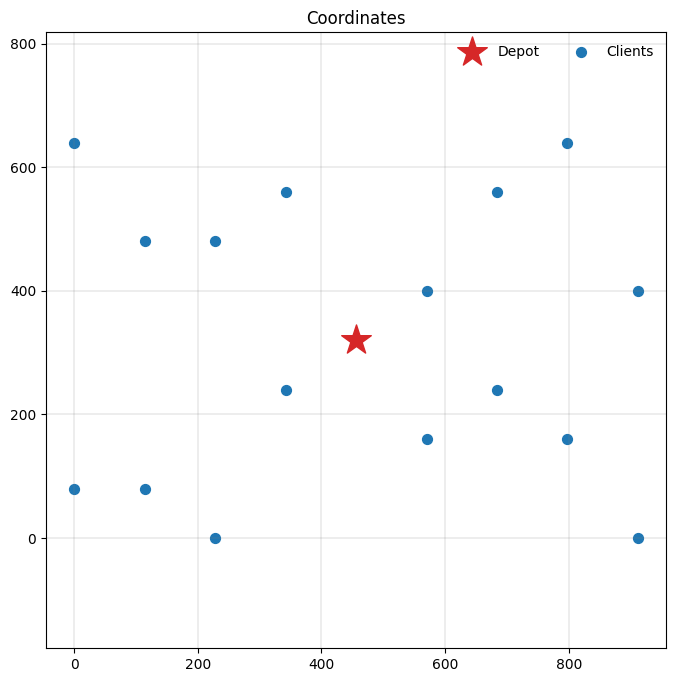

In [ ]:
import matplotlib.pyplot as plt

from pyvrp.plotting import plot_coordinates

_, ax = plt.subplots(figsize=(8, 8))
plot_coordinates(m.data(), ax=ax)

The instance looks good, so we are ready to solve it.
Let's do so with a second of runtime, and display the search progress using the `display` argument on `Model.solve`.

In [ ]:
from pyvrp.stop import MaxRuntime

res = m.solve(stop=MaxRuntime(1), display=True)  # one second

PyVRP v0.10.1

Solving an instance with:
    1 depot
    16 clients
    4 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      0s |  39     6347     6208 |  43     6784     6093
     1000      0s |  39     6347     6208 |  62     6079     5484
     1500      1s |  44     6332     6208 |  34     6227     5239
     2000      1s |  57     6303     6208 |  34     6674     6093

Search terminated in 1.00s after 2313 iterations.
Best-found solution has cost 6208.

Solution results
    # routes: 4
   # clients: 16
   objective: 6208
    distance: 6208
    duration: 0
# iterations: 2313
    run-time: 1.00 seconds



By passing the `display` argument, PyVRP displays statistics about the solver progress and the instance being solved.
In particular, it outputs the sizes of the feasible and infeasible solution pools, their average objective values, and the objective of the best solutions in either pool.
A heuristic improvement is indicated by a `H` at the start of a line.

Let's print the solution we have found to see the routes.

In [ ]:
print(res)

Solution results
    # routes: 4
   # clients: 16
   objective: 6208
    distance: 6208
    duration: 0
# iterations: 2313
    run-time: 1.00 seconds

Routes
------
Route #1: 7 1 4 3 
Route #2: 13 15 11 12 
Route #3: 5 2 6 8 
Route #4: 10 16 14 9 



Good! Our solution attains the same objective value as the optimal solution OR-Tools finds.
Let's inspect our solution more closely.

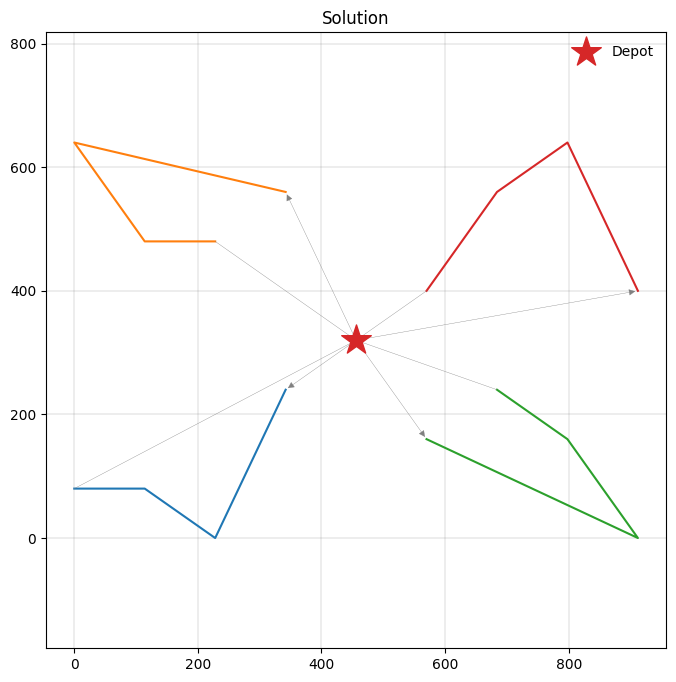

In [ ]:
from pyvrp.plotting import plot_solution

_, ax = plt.subplots(figsize=(8, 8))
plot_solution(res.best, m.data(), ax=ax)

We have just solved our first vehicle routing problem using PyVRP!

.. warning::
   PyVRP automatically converts all numeric input values to integers.
   If your data has decimal values, you must scale and convert them to integers first to avoid unexpected behaviour.


### VRP with time windows


Besides the capacitated VRP, PyVRP also supports the VRP with time windows.
Let's see if we can also solve such an instance, again following the [OR-Tools documentation](https://developers.google.com/optimization/routing/vrptw).
Like in the OR-Tools example, we will ignore capacity restrictions, and give each vehicle a maximum route duration of 30.
Unlike the OR-Tools example, we still aim to minimise the total travel _distance_, not _duration_.

In [ ]:
# fmt: off
DURATION_MATRIX = [
        [0, 6, 9, 8, 7, 3, 6, 2, 3, 2, 6, 6, 4, 4, 5, 9, 7],
        [6, 0, 8, 3, 2, 6, 8, 4, 8, 8, 13, 7, 5, 8, 12, 10, 14],
        [9, 8, 0, 11, 10, 6, 3, 9, 5, 8, 4, 15, 14, 13, 9, 18, 9],
        [8, 3, 11, 0, 1, 7, 10, 6, 10, 10, 14, 6, 7, 9, 14, 6, 16],
        [7, 2, 10, 1, 0, 6, 9, 4, 8, 9, 13, 4, 6, 8, 12, 8, 14],
        [3, 6, 6, 7, 6, 0, 2, 3, 2, 2, 7, 9, 7, 7, 6, 12, 8],
        [6, 8, 3, 10, 9, 2, 0, 6, 2, 5, 4, 12, 10, 10, 6, 15, 5],
        [2, 4, 9, 6, 4, 3, 6, 0, 4, 4, 8, 5, 4, 3, 7, 8, 10],
        [3, 8, 5, 10, 8, 2, 2, 4, 0, 3, 4, 9, 8, 7, 3, 13, 6],
        [2, 8, 8, 10, 9, 2, 5, 4, 3, 0, 4, 6, 5, 4, 3, 9, 5],
        [6, 13, 4, 14, 13, 7, 4, 8, 4, 4, 0, 10, 9, 8, 4, 13, 4],
        [6, 7, 15, 6, 4, 9, 12, 5, 9, 6, 10, 0, 1, 3, 7, 3, 10],
        [4, 5, 14, 7, 6, 7, 10, 4, 8, 5, 9, 1, 0, 2, 6, 4, 8],
        [4, 8, 13, 9, 8, 7, 10, 3, 7, 4, 8, 3, 2, 0, 4, 5, 6],
        [5, 12, 9, 14, 12, 6, 6, 7, 3, 3, 4, 7, 6, 4, 0, 9, 2],
        [9, 10, 18, 6, 8, 12, 15, 8, 13, 9, 13, 3, 4, 5, 9, 0, 9],
        [7, 14, 9, 16, 14, 8, 5, 10, 6, 5, 4, 10, 8, 6, 2, 9, 0],
]
TIME_WINDOWS = [
        (0, 999),  # location 0 - the depot (modified to be unrestricted)
        (7, 12),   # location 1
        (10, 15),  # location 2
        (16, 18),  # location 3
        (10, 13),  # location 4
        (0, 5),    # location 5
        (5, 10),   # location 6
        (0, 4),    # location 7
        (5, 10),   # location 8
        (0, 3),    # location 9
        (10, 16),  # location 10
        (10, 15),  # location 11
        (0, 5),    # location 12
        (5, 10),   # location 13
        (7, 8),    # location 14
        (10, 15),  # location 15
        (11, 15),  # location 16
]
# fmt: on

We now need to specify the time windows for all locations, and the duration of travelling along each edge.
The depot's time window is applied to the vehicle type.

In [ ]:
m = Model()
m.add_vehicle_type(
    4,
    max_duration=30,
    tw_early=TIME_WINDOWS[0][0],
    tw_late=TIME_WINDOWS[0][1],
)

depot = m.add_depot(x=COORDS[0][0], y=COORDS[0][1])
clients = [
    m.add_client(
        x=COORDS[idx][0],
        y=COORDS[idx][1],
        tw_early=TIME_WINDOWS[idx][0],
        tw_late=TIME_WINDOWS[idx][1],
    )
    for idx in range(1, len(COORDS))
]

locations = [depot] + clients
for frm_idx, frm in enumerate(locations):
    for to_idx, to in enumerate(locations):
        distance = abs(frm.x - to.x) + abs(frm.y - to.y)  # Manhattan
        duration = DURATION_MATRIX[frm_idx][to_idx]
        m.add_edge(frm, to, distance=distance, duration=duration)

In [ ]:
res = m.solve(stop=MaxRuntime(1), display=False)  # one second
print(res)

Solution results
    # routes: 4
   # clients: 16
   objective: 6528
    distance: 6528
    duration: 79
# iterations: 1907
    run-time: 1.00 seconds

Routes
------
Route #1: 7 1 4 3 
Route #2: 12 13 15 11 
Route #3: 9 14 16 
Route #4: 5 8 6 2 10 



Due to the hard time windows requirements, the total travel distance has increased slightly compared to our solution for the capacitated VRP.
Let's have a look at the new solution.

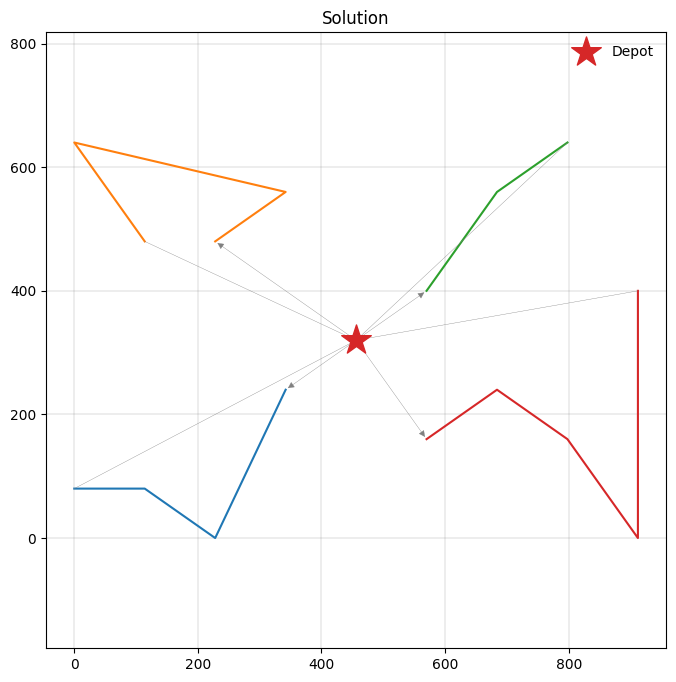

In [ ]:
_, ax = plt.subplots(figsize=(8, 8))
plot_solution(res.best, m.data(), ax=ax)

### Multi-depot VRP with time windows

Let's now solve a VRP with multiple depots and time windows.
We consider two depots, and two vehicles per depot that have to start and end their routes at their respective depot.
PyVRP additionally supports vehicles ending their routes at a different depot from where they start, by passing different depots to the `start_depot` and `end_depot` arguments of the `VehicleType`.

We will re-use some of the data from the VRPTW case, but change the time window data slightly: the first client now becomes the second depot.

In [ ]:
# fmt: off
TIME_WINDOWS = [
    (0, 999),  # location 0 - a depot (modified to be unrestricted)
    (0, 999),  # location 1 - a depot (modified to be unrestricted)
    (10, 15),  # location 2
    (16, 18),  # location 3
    (10, 13),  # location 4
    (0, 5),    # location 5
    (5, 10),   # location 6
    (0, 4),    # location 7
    (5, 10),   # location 8
    (0, 3),    # location 9
    (10, 16),  # location 10
    (10, 15),  # location 11
    (0, 5),    # location 12
    (5, 10),   # location 13
    (7, 8),    # location 14
    (10, 15),  # location 15
    (11, 15),  # location 16
]
# fmt: on

In [ ]:
m = Model()

for idx in range(2):
    depot = m.add_depot(x=COORDS[idx][0], y=COORDS[idx][1])

    # Two vehicles at each depot, with 30 maximum route duration.
    m.add_vehicle_type(
        2,
        start_depot=depot,
        end_depot=depot,
        max_duration=30,
        tw_early=TIME_WINDOWS[idx][0],
        tw_late=TIME_WINDOWS[idx][1],
    )

for idx in range(2, len(COORDS)):
    m.add_client(
        x=COORDS[idx][0],
        y=COORDS[idx][1],
        tw_early=TIME_WINDOWS[idx][0],
        tw_late=TIME_WINDOWS[idx][1],
    )

for frm_idx, frm in enumerate(m.locations):
    for to_idx, to in enumerate(m.locations):
        distance = abs(frm.x - to.x) + abs(frm.y - to.y)  # Manhattan
        duration = DURATION_MATRIX[frm_idx][to_idx]
        m.add_edge(frm, to, distance=distance, duration=duration)

Let's have a look at the modified data instance to familiarise ourself with the changes.

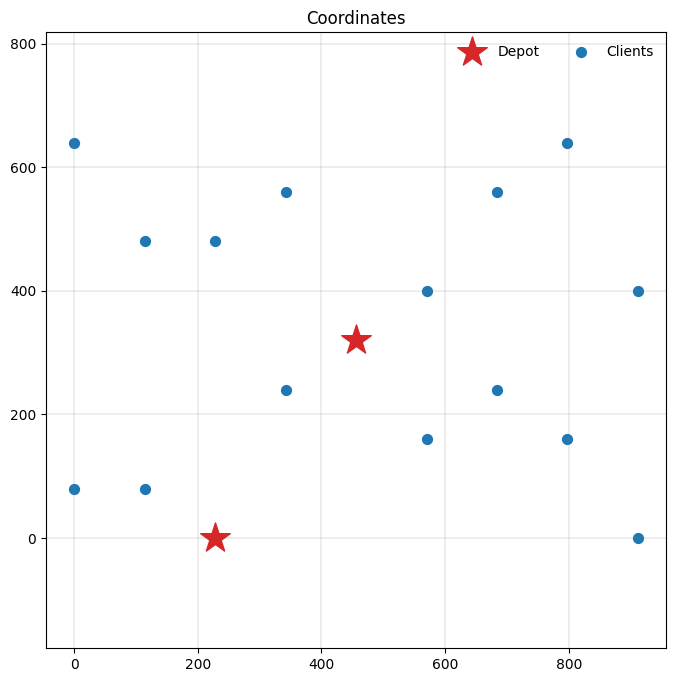

In [ ]:
_, ax = plt.subplots(figsize=(8, 8))
plot_coordinates(m.data(), ax=ax)

Let's solve the instance.

In [ ]:
res = m.solve(stop=MaxRuntime(1), display=False)  # one second
print(res)

Solution results
    # routes: 4
   # clients: 15
   objective: 6004
    distance: 6004
    duration: 69
# iterations: 2083
    run-time: 1.00 seconds

Routes
------
Route #1: 9 14 16 
Route #2: 7 5 8 6 2 10 
Route #3: 4 3 
Route #4: 12 13 15 11 



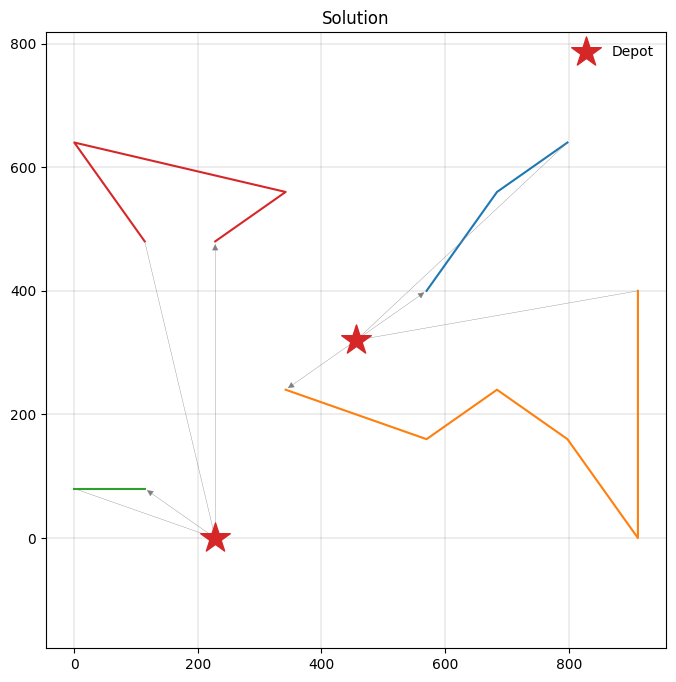

In [ ]:
_, ax = plt.subplots(figsize=(8, 8))
plot_solution(res.best, m.data(), ax=ax)

### Prize-collecting VRP

We now have a basic familiarity with PyVRP's `Model` interface, but have not seen some of its additional features yet.
In this short section we will discuss _optional_ clients, which offer a reward (a prize) when they are visited, but are not required for feasibility.
This VRP variant is often called a prize-collecting VRP, and PyVRP supports this out-of-the-box.

Let's stick to the multiple depot setting, and also define a `PRIZES` list that provides the prizes of visiting each client.

In [ ]:
# fmt: off
PRIZES = [
    0,    # location 0 - a depot
    0,    # location 1 - a depot
    334,  # location 2
    413,  # location 3
    295,  # location 4
    471,  # location 5
    399,  # location 6
    484,  # location 7
    369,  # location 8
    410,  # location 9
    471,  # location 10
    382,  # location 11
    347,  # location 12
    380,  # location 13
    409,  # location 14
    302,  # location 15
    411,  # location 16
]
# fmt: on

When modelling optional clients, it is important to provide both a reward (the `prize` argument to `add_client`), and to mark the client as optional by passing `required=False`:

In [ ]:
m = Model()

for idx in range(2):
    depot = m.add_depot(x=COORDS[idx][0], y=COORDS[idx][1])
    m.add_vehicle_type(
        2,
        start_depot=depot,
        end_depot=depot,
        tw_early=TIME_WINDOWS[idx][0],
        tw_late=TIME_WINDOWS[idx][1],
    )


for idx in range(2, len(COORDS)):
    m.add_client(
        x=COORDS[idx][0],
        y=COORDS[idx][1],
        tw_early=TIME_WINDOWS[idx][0],
        tw_late=TIME_WINDOWS[idx][1],
        prize=PRIZES[idx],
        required=False,
    )

for frm_idx, frm in enumerate(m.locations):
    for to_idx, to in enumerate(m.locations):
        distance = abs(frm.x - to.x) + abs(frm.y - to.y)  # Manhattan
        duration = DURATION_MATRIX[frm_idx][to_idx]
        m.add_edge(frm, to, distance=distance, duration=duration)

In [ ]:
res = m.solve(stop=MaxRuntime(1), display=False)  # one second
print(res)

Solution results
    # routes: 3
   # clients: 10
   objective: 5145
    distance: 3400
    duration: 40
# iterations: 2375
    run-time: 1.00 seconds

Routes
------
Route #1: 7 5 6 8 
Route #2: 9 14 16 10 
Route #3: 4 3 



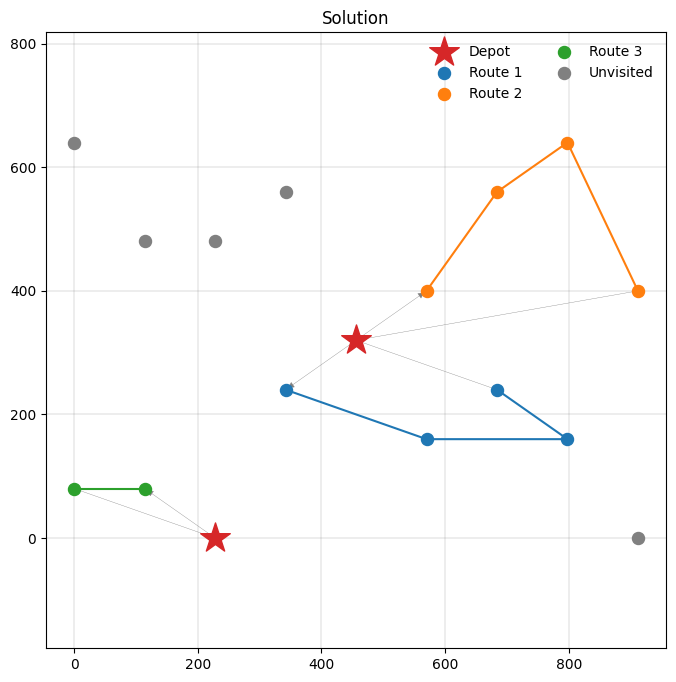

In [ ]:
_, ax = plt.subplots(figsize=(8, 8))
plot_solution(res.best, m.data(), plot_clients=True, ax=ax)

Some clients are not visited in the figure above.
These clients are too far from other locations for their prizes to be worth the additional travel cost of visiting.
Thus, PyVRP's solver opts not to visit such optional clients.

### VRP with simultaneous pickup and delivery

We will now consider the VRP with simultaneous pickup and delivery.
In this problem variant, clients request items from the depot, and also produce return shipments that needs to be delivered back to the depot after visiting the client.
Thus, there are both deliveries from the depot to the clients, and pickups from the clients to the depot.

Let's remain in the multi-depot, prize-collecting world we entered through the last example.
We first define a `LOADS` list that tracks the delivery and pickup amount for each location:

In [ ]:
# fmt: off
LOADS = [
    (0, 0),   # location 0 - a depot
    (0, 0),   # location 1 - a depot
    (1, 4),   # location 2 - simultaneous pickup and delivery
    (2, 0),   # location 3 - pure delivery
    (0, 5),   # location 4 - pure pickup
    (6, 3),   # location 5 - simultaneous pickup and delivery
    (4, 7),   # location 6 - simultaneous pickup and delivery
    (11, 0),  # location 7 - pure delivery
    (3, 0),   # location 8 - pure delivery
    (0, 5),   # location 9 - pure pickup
    (6, 4),   # location 10 - simultaneous pickup and delivery
    (1, 4),   # location 11 - simultaneous pickup and delivery
    (0, 3),   # location 12 - pure pickup
    (6, 0),   # location 13 - pure delivery
    (3, 2),   # location 14 - simultaneous pickup and delivery
    (4, 3),   # location 15 - simultaneous pickup and delivery
    (0, 6),   # location 16 - pure pickup
]
# fmt: on

In [ ]:
m = Model()

for idx in range(2):
    depot = m.add_depot(x=COORDS[idx][0], y=COORDS[idx][1])
    m.add_vehicle_type(
        2,
        start_depot=depot,
        end_depot=depot,
        capacity=15,
        tw_early=TIME_WINDOWS[idx][0],
        tw_late=TIME_WINDOWS[idx][1],
    )


for idx in range(2, len(COORDS)):
    m.add_client(
        x=COORDS[idx][0],
        y=COORDS[idx][1],
        tw_early=TIME_WINDOWS[idx][0],
        tw_late=TIME_WINDOWS[idx][1],
        delivery=LOADS[idx][0],
        pickup=LOADS[idx][1],
        prize=PRIZES[idx],
        required=False,
    )

for frm_idx, frm in enumerate(m.locations):
    for to_idx, to in enumerate(m.locations):
        distance = abs(frm.x - to.x) + abs(frm.y - to.y)  # Manhattan
        duration = DURATION_MATRIX[frm_idx][to_idx]
        m.add_edge(frm, to, distance=distance, duration=duration)

In [ ]:
res = m.solve(stop=MaxRuntime(1), display=False)  # one second
print(res)

Solution results
    # routes: 3
   # clients: 6
   objective: 5375
    distance: 1940
    duration: 21
# iterations: 2364
    run-time: 1.00 seconds

Routes
------
Route #1: 9 5 8 
Route #2: 7 
Route #3: 4 3 



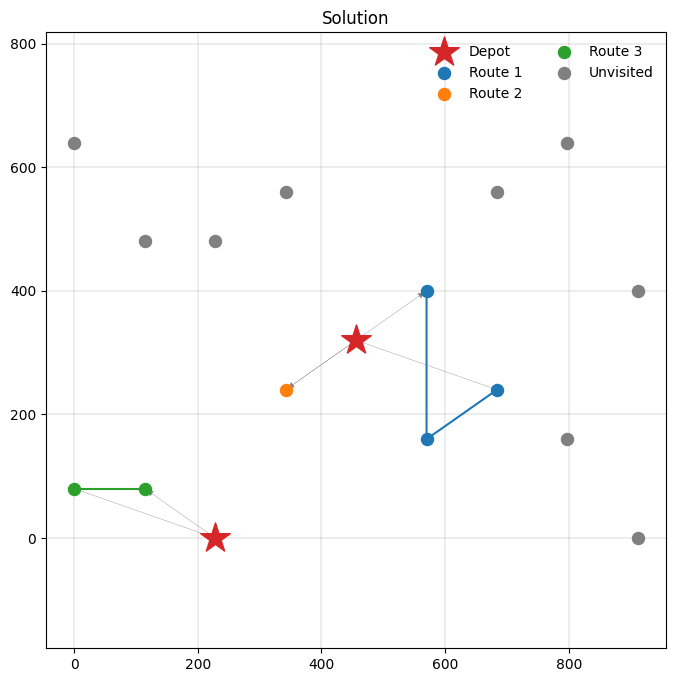

In [ ]:
_, ax = plt.subplots(figsize=(8, 8))
plot_solution(res.best, m.data(), plot_clients=True, ax=ax)

### VRP with zone restrictions

We have seen several VRP variants in this notebook already.
Let us conclude with a variant showing how to model zone restrictions, where some vehicles are not allowed to visit clients located inside a particular area.
Such restrictions commonly apply in urban environments with emission zones, where several types of (heavy) trucks may not enter.
We will add one regular vehicle type to the model that can enter the restricted zone.
Additionally, we will consider a vehicle type that cannot enter the restricted zone, and has to travel from the first to the second depot.

Suppose we have a rectangular zone defined by the following `(x, y)` coordinates.

In [ ]:
ZONE = ((500, 125), (850, 275))


def in_zone(client) -> bool:
    return (
        ZONE[0][0] <= client.x <= ZONE[1][0]
        and ZONE[0][1] <= client.y <= ZONE[1][1]
    )

We can now set up a `Model` as follows, using routing profiles to restrict which vehicle types can enter the zone to visit clients there.

In [ ]:
m = Model()

depot1 = m.add_depot(x=COORDS[0][0], y=COORDS[0][1])
depot2 = m.add_depot(x=COORDS[1][0], y=COORDS[1][1])

regular = m.add_profile()
m.add_vehicle_type(
    2,
    start_depot=depot1,
    end_depot=depot1,
    tw_early=TIME_WINDOWS[0][0],
    tw_late=TIME_WINDOWS[0][1],
    profile=regular,
)

restricted = m.add_profile()
m.add_vehicle_type(
    2,
    start_depot=depot1,
    end_depot=depot2,
    tw_early=TIME_WINDOWS[1][0],
    tw_late=TIME_WINDOWS[1][1],
    profile=restricted,
)

for idx in range(2, len(COORDS)):
    m.add_client(
        x=COORDS[idx][0],
        y=COORDS[idx][1],
        tw_early=TIME_WINDOWS[idx][0],
        tw_late=TIME_WINDOWS[idx][1],
    )

for frm_idx, frm in enumerate(m.locations):
    for to_idx, to in enumerate(m.locations):
        distance = abs(frm.x - to.x) + abs(frm.y - to.y)  # Manhattan
        duration = DURATION_MATRIX[frm_idx][to_idx]

        # Edges without a specific profile assignment are added to all
        # profiles, unless a profile-specific edge overrides them.
        m.add_edge(frm, to, distance=distance, duration=duration)

        if frm_idx != to_idx and in_zone(to):
            # Here we specify an edge with a high distance and duration
            # for the restricted profile. This ensures vehicles with
            # that profile do not travel over this edge.
            m.add_edge(
                frm,
                to,
                distance=1_000,
                duration=1_000,
                profile=restricted,
            )

In [ ]:
res = m.solve(stop=MaxRuntime(1), display=False)  # one second

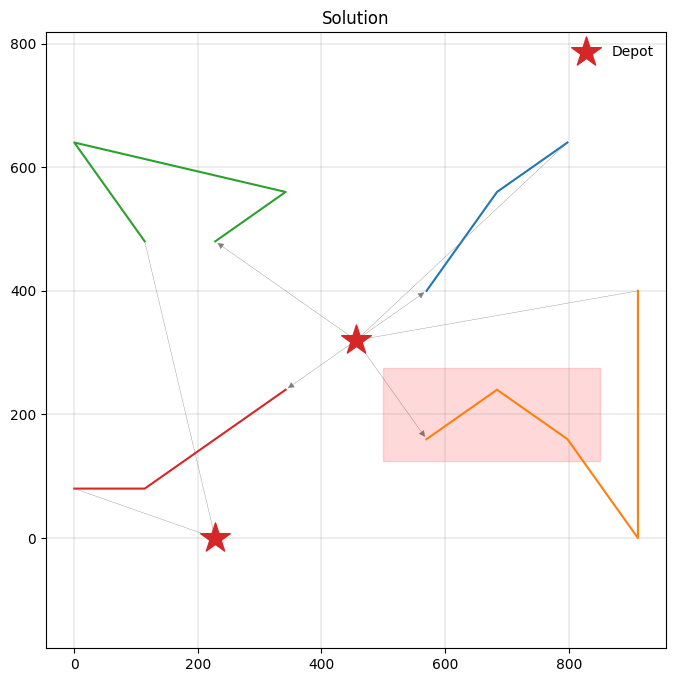

In [ ]:
_, ax = plt.subplots(figsize=(8, 8))
plot_solution(res.best, m.data(), ax=ax)

# Highlight the restricted zone.
ax.fill_between(
    [ZONE[0][0], ZONE[1][0]],
    ZONE[0][1],
    ZONE[1][1],
    color="red",
    alpha=0.15,
);

This concludes the brief tutorial: you now know how to model and solve vehicle routing problems using PyVRP's `Model` interface.
PyVRP supports several additional VRP variants we have not covered here.
Have a look at the VRP introduction and other documentation pages to see how those can be modelled and solved.

In [25]:
import pandas as pd

In [28]:
vehicles_df = pd.read_csv("https://raw.githubusercontent.com/leonlan/tsp/refs/heads/main/data/vehicles.csv")
depots_df = pd.read_csv("https://raw.githubusercontent.com/leonlan/tsp/refs/heads/main/data/depots.csv")
clients_df = pd.read_csv("https://raw.githubusercontent.com/leonlan/tsp/refs/heads/main/data/clients.csv")

In [29]:
depots_df.head()

,Name,Latitude,Longitude
0,Amsterdam,52.313419,4.893382
1,Rotterdam,51.940908,4.597807
2,Utrecht,52.062220,5.179573
3,Groningen,53.187942,6.620768
4,Arnhem,51.992679,6.018603


In [31]:
clients_df.head()

,Name,Latitude,Longitude,Time window early,Time window late,Demand,Service time
0,NaN,50.784313,5.791205,746,1052,3,6
1,NaN,50.850873,5.768327,619,1039,4,8
2,NaN,50.858271,5.965312,492,833,1,2
3,NaN,50.898203,5.697817,524,991,1,2
4,NaN,50.917997,5.885358,481,766,2,4


In [37]:
import pandas as pd
import folium
from IPython.display import display
import io
from dataclasses import dataclass
import random
import numpy as np
from copy import copy

In [65]:
def draw(df, depots_df, tour=None):
    """
    Draws a map with location markers and lines connecting points according
    to a specified tour.

    Parameters:
    -----------
    df: pd.DataFrame
        DataFrame containing at minimum 'Latitude' and 'Longitude' columns.
    tour: list
        List of indices specifying the order to connect points.
        If None, no lines are drawn.
    """
    center_lat = 52.1326
    center_lon = 5.2913
    zoom_start = 7
    width = 400
    height = 420
    point_radius = 0.1
    point_color = "red"
    line_color = "blue"
    line_weight = 2

    fmap = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=zoom_start,
        tiles="Cartodb positron",
        width=width,
        height=height,
    )

    for _, row in df.iterrows():
        popup = f"{row['Name']}" if "Name" in df.columns else None
        folium.CircleMarker(
            location=[row["Latitude"], row["Longitude"]],
            radius=point_radius,
            popup=popup,
            color=point_color,
            fill=True,
            fill_color=point_color,
            fill_opacity=0.6,
        ).add_to(fmap)

    if tour is not None:
        coordinates = []
        for idx in tour:
            row = df.iloc[idx]
            coordinates.append([row["Latitude"], row["Longitude"]])

        if tour[0] != tour[-1]:
            coordinates.append(coordinates[0])

        folium.PolyLine(
            locations=coordinates,
            color=line_color,
            weight=line_weight,
            opacity=0.7,
        ).add_to(fmap)

    for _, row in depots_df.iterrows():
        folium.CircleMarker(
            location=[row["Latitude"], row["Longitude"]],
            radius=5,
            color="blue",
            fill=True,
            fill_color="blue",
            fill_opacity=0.6,
        ).add_to(fmap)

    return fmap

In [66]:
fmap = draw(clients_df, depots_df)
fmap

In [45]:
vehicles_df.head()

,Name,Number available,Capacity,Max duration (minutes)
0,Amsterdam,50,100,480
1,Rotterdam,20,50,480
2,Utrecht,30,100,480
3,Groningen,10,40,480
4,Arnhem,20,60,480


In [50]:
def haversine(coords: list[tuple[int, int]]) -> np.ndarray:
    """
    Converts coordinates to a Haversine distance matrix (in meters).
    """

    from sklearn.metrics.pairwise import haversine_distances
    from math import radians

    RADIUS_EARTH = 6371000 # meters

    coords_rad = np.array(
        [[radians(lat), radians(lon)] for lat, lon in coords]
    )
    dist_matrix = haversine_distances(coords_rad)
    dist_meters = (dist_matrix * RADIUS_EARTH).round() # rads to meters
    return dist_meters

In [69]:
model = Model()

for _, row in depots_df.iterrows():
    x = int(row["Longitude"] * 10000)
    y = int(row["Latitude"] * 10000)
    model.add_depot(x, y)

for _, row in clients_df.iterrows():
    x = int(row["Longitude"] * 10000)
    y = int(row["Latitude"] * 10000)
    service_time = row["Service time"]
    delivery = int(row["Demand"])
    tw_early = row["Time window early"]
    tw_late = row["Time window late"]
    model.add_client(x, y, delivery, service_duration=service_time, tw_early=tw_early, tw_late=tw_late)

for _, row in vehicles_df.iterrows():
    num_available = row["Number available"]
    capacity = row["Capacity"]
    depot_name = row["Name"]
    depot_idx = depots_df["Name"].tolist().index(depot_name)
    depot = model.locations[depot_idx]
    max_duration = row["Max duration (minutes)"]
    model.add_vehicle_type(num_available, capacity=capacity,
                           start_depot=depot, end_depot=depot, max_duration=max_duration)

# Distances and durations
lats = depots_df["Latitude"].tolist() + clients_df["Latitude"].tolist()
longs = depots_df["Longitude"].tolist() + clients_df["Longitude"].tolist()
coords = list(zip(lats, longs))
dist_matrix = haversine(coords)

for idx1, loc1 in enumerate(model.locations):
    for idx2, loc2 in enumerate(model.locations):
        dist = dist_matrix[idx1, idx2] # in meters
        duration = dist / 1000 # in km -> 60km/u -> 1 km/min -> minutes
        model.add_edge(loc1, loc2, distance=dist, duration=duration)

In [70]:
result = model.solve(MaxRuntime(10))

PyVRP v0.10.1

Solving an instance with:
    10 depots
    107 clients
    255 vehicles (10 vehicle types)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      6s |  31  1652190  1598440 |  26  1640805  1592659

Search terminated in 10.02s after 962 iterations.
Best-found solution has cost 1595636.

Solution results
    # routes: 13
   # clients: 107
   objective: 1595636
    distance: 1595636
    duration: 2542
# iterations: 962
    run-time: 10.02 seconds



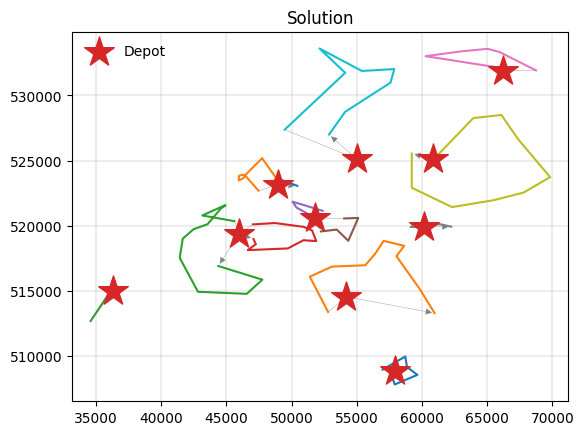

In [71]:
plot_solution(result.best, model.data())